In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

### Import Dataset

In [41]:
df = pd.read_excel('../../../data_set/online_dataset/dataset2.xlsx')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             5000 non-null   int64  
 1   Gender                          5000 non-null   object 
 2   Weight                          5000 non-null   float64
 3   Diabetes                        5000 non-null   bool   
 4   Hypertension                    5000 non-null   bool   
 5   Kidney Failure Cause            5000 non-null   object 
 6   Pre-Dialysis Blood Pressure     5000 non-null   int64  
 7   During-Dialysis Blood Pressure  5000 non-null   int64  
 8   Post-Dialysis Blood Pressure    5000 non-null   int64  
 9   Heart Rate                      5000 non-null   int64  
 10  Creatinine                      5000 non-null   float64
 11  Urea                            5000 non-null   float64
 12  Potassium                       50

### Preprocess Dataset

In [43]:
df.Hypertension

0        True
1       False
2        True
3       False
4       False
        ...  
4995     True
4996     True
4997    False
4998     True
4999    False
Name: Hypertension, Length: 5000, dtype: bool

In [44]:
columns_to_convert = ['Diabetes', 'Hypertension']
df[columns_to_convert] = df[columns_to_convert].astype(int)

In [45]:
df.Hypertension

0       1
1       0
2       1
3       0
4       0
       ..
4995    1
4996    1
4997    0
4998    1
4999    0
Name: Hypertension, Length: 5000, dtype: int64

In [46]:
df = df.drop(['Age', 'Gender', 'Weight'], axis=1)

In [47]:
df = df.drop(['Kidney Failure Cause', 'Dialysate Composition', 'Vascular Access Type', 'Dialyzer Type', 'Disease Severity'], axis=1)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Diabetes                        5000 non-null   int64  
 1   Hypertension                    5000 non-null   int64  
 2   Pre-Dialysis Blood Pressure     5000 non-null   int64  
 3   During-Dialysis Blood Pressure  5000 non-null   int64  
 4   Post-Dialysis Blood Pressure    5000 non-null   int64  
 5   Heart Rate                      5000 non-null   int64  
 6   Creatinine                      5000 non-null   float64
 7   Urea                            5000 non-null   float64
 8   Potassium                       5000 non-null   float64
 9   Hemoglobin                      5000 non-null   float64
 10  Hematocrit                      5000 non-null   float64
 11  Albumin                         5000 non-null   float64
 12  Dialysis Duration (hours)       50

#### Separate x and y

In [49]:
X = df.drop(['Diabetes', 'Hypertension'], axis=1)
y = df['Hypertension']
z = df['Diabetes']

In [92]:
print("Hemodialysis distribution in dataset set: (0:No Hemodialysis, 1:Has Hemodialysis)")
print(pd.Series(y).value_counts())

Hemodialysis distribution in dataset set: (0:No Hemodialysis, 1:Has Hemodialysis)
Hypertension
0    2536
1    2464
Name: count, dtype: int64


### Train XGBoost model

In [55]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42 )

In [84]:
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    scale_pos_weight=100,  # optional: help with imbalance if not using SMOTE
    random_state=42
)

In [85]:
model.fit(X_train, y_train)

C:\Users\Lakshitha Kaveen\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:55:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [86]:
print("Class distribution in training set:")
print(pd.Series(y_train).value_counts())

Class distribution in training set:
Hypertension
0    2029
1    1971
Name: count, dtype: int64


### Prediction

In [87]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

### Evaluation

In [88]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred,digits=4))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Average Precision Score (AUC-PR):", average_precision_score(y_test, y_proba))

Accuracy: 0.477

Classification Report:
               precision    recall  f1-score   support

           0     0.4245    0.0888    0.1468       507
           1     0.4832    0.8763    0.6229       493

    accuracy                         0.4770      1000
   macro avg     0.4539    0.4825    0.3849      1000
weighted avg     0.4535    0.4770    0.3815      1000

ROC AUC Score: 0.4617905109401442
Average Precision Score (AUC-PR): 0.47258631661784656


In [89]:
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


Confusion Matrix:
 [[ 45 462]
 [ 61 432]]


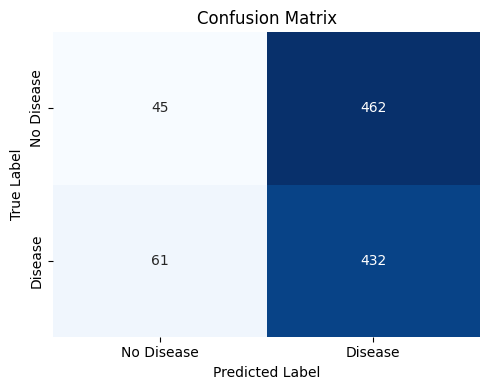

In [90]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Disease', 'Disease'], 
            yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()